# Data Mining Project
This notebook demonstrates the data preprocessing and analysis steps for the Bike Rentals dataset in San Jose. The goal is to clean the data, extract relevant features, and perform exploratory data analysis to derive insights.

## 1: DATA PREPROCESSING WITH SPARK
In this step I load, clean and merge datasets using Spark

In [ ]:
# Libraries for section 1
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, to_date, date_format, when, count, desc, round, lit, sum, dayofweek, unix_timestamp, avg, hour, floor, expr #ultimo non serve, avg, expr
import matplotlib.pyplot as plt
import pandas as pd

In [43]:
# Initialize Spark session
spark = SparkSession.builder.appName("BikeShare Data Preprocessing").getOrCreate()

### Step 1.1: Load datasets

In [44]:
trip_data = spark.read.csv(r"C:\Users\utente\Desktop\UNITN\data mining\Project\data bike rentals san jose\trip_data.csv", header=True, inferSchema=True)
station_data = spark.read.csv(r"C:\Users\utente\Desktop\UNITN\data mining\Project\data bike rentals san jose\station_data.csv", header=True, inferSchema=True)
weather_data = spark.read.csv(r"C:\Users\utente\Desktop\UNITN\data mining\Project\data bike rentals san jose\weather_data.csv", header=True, inferSchema=True)

### Step 1.2: Preparation of datasets
##### TRIP DATA:
We process the `Start Date` and `End Date` columns to extract:
- **Start_date**: The date when the trip started.
- **Start_time**: The time when the trip started.
- **End_date**: The date when the trip ended.
- **End_time**: The time when the trip ended.

The original `Start Date` and `End Date` columns are dropped after extraction.

In [45]:
# Convert "Start Date" and "End Date" to timestamp 
trip_data = trip_data.withColumn("Start Date", to_timestamp(col("Start Date"), "dd/MM/yyyy HH:mm")) \
                     .withColumn("End Date", to_timestamp(col("End Date"), "dd/MM/yyyy HH:mm"))

# Extract Start_date and Start_time
trip_data = trip_data.withColumn("Start_date", to_date(col("Start Date"))) \
                     .withColumn("Start_time", date_format(col("Start Date"), "HH:mm:ss"))

# Extract End_date and End_time
trip_data = trip_data.withColumn("End_date", to_date(col("End Date"))) \
                     .withColumn("End_time", date_format(col("End Date"), "HH:mm:ss"))

trip_data = trip_data.drop("Start Date", "End Date")

During the year some stations changed number and slightly changed latitude and longitude, but mantained the same name.

For consistency I decided to keep the most recent version of each station by updating the station numbers and position. This approximation of the data implies loosing some information, but it is necessary for a better understanding of the final results.

In [46]:
# Define mapping of old station IDs to new ones (keeping the most recent version)
station_id_mapping = {
    23: 85,
    25: 86,
    49: 87,
    69: 88,
    72: 90,  # Most recent version
    89: 90   # Ensure 89 is also mapped to 90
}

# Replace station IDs directly in trip_data
for old_id, new_id in station_id_mapping.items():
    trip_data = trip_data.withColumn("Start Station", when(col("Start Station") == old_id, new_id).otherwise(col("Start Station")))
    trip_data = trip_data.withColumn("End Station", when(col("End Station") == old_id, new_id).otherwise(col("End Station")))

# Validate the DataFrame safely
try:
    row_count = trip_data.count()
    print(f"Row count: {row_count}")
    trip_data.limit(5).show()
except Exception as e:
    print(f"Error displaying trip_data: {e}")

Row count: 354152
+-------+-------------+-----------+---------------+----------+----------+----------+--------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|Start_time|  End_date|End_time|
+-------+-------------+-----------+---------------+----------+----------+----------+--------+
| 913460|           50|         70|     Subscriber|2015-08-31|  23:26:00|2015-08-31|23:39:00|
| 913459|           31|         27|     Subscriber|2015-08-31|  23:11:00|2015-08-31|23:28:00|
| 913455|           47|         64|     Subscriber|2015-08-31|  23:13:00|2015-08-31|23:18:00|
| 913454|           10|          8|     Subscriber|2015-08-31|  23:10:00|2015-08-31|23:17:00|
| 913453|           51|         60|       Customer|2015-08-31|  23:09:00|2015-08-31|23:22:00|
+-------+-------------+-----------+---------------+----------+----------+----------+--------+



##### WEATHER DATA: Convert the `Date` column to date type

In [47]:
weather_data = weather_data.withColumn("Date", to_date(col("Date"), "dd/MM/yyyy"))

##### STATION DATA: Define the city-to-zip mapping and replace the `City` column with mapped Zip codes

In [48]:
city_to_zip = {
    "San Francisco": "94107",
    "Redwood City": "94063",
    "Palo Alto": "94301",
    "Mountain View": "94041",
    "San Jose": "95113"
}

# Start with the existing DataFrame
station_data_updated = station_data

# Replace city values with zip codes
for city, zip_code in city_to_zip.items():
    station_data_updated = station_data_updated.withColumn(
        "city",
        when(col("city") == city, zip_code).otherwise(col("city"))
    )

### Step 1.3: Merge datasets using SQL queries

In [49]:
# Register dataframes as temporary SQL views
trip_data.createOrReplaceTempView("trip")
weather_data.createOrReplaceTempView("weather")
station_data_updated.createOrReplaceTempView("station") 

In [50]:
# Dimension of the datasets
print(f"Trip data rows: {trip_data.count()}")
print(f"Weather data rows: {weather_data.count()}")
print(f"Station data rows: {station_data_updated.count()}")

Trip data rows: 354152
Weather data rows: 1825
Station data rows: 76


In [51]:
final_data = spark.sql("""
    SELECT DISTINCT
        -- Trip details
        t.`Trip ID`, t.`Start Station`, t.`End Station`, t.`Subscriber Type`, t.`Start_date`, 
        t.`End_date`, t.`Start_time`, t.`End_time`, 
        
        -- Weather details
        w.`Max TemperatureF`, w.`Mean TemperatureF`, w.`Min TemperatureF`,     
        w.`Max Sea Level PressureIn`, w.`Mean Sea Level PressureIn`, 
        w.`Min Sea Level PressureIn`, w.`Max Wind SpeedMPH`,
        w.`PrecipitationIn`, w.`CloudCover`, w.`Zip`,
                       
        -- Station details
        s1.Name AS Start_Station_Name, s1.City AS Start_Station_City, s1.Lat AS Start_Lat,
        s1.Long AS Start_Long, s1.`Dock Count` AS Start_dock_count,
        s2.Name AS End_Station_Name, s2.City AS End_Station_City, s2.Lat AS End_Lat,
        s2.Long AS End_Long, s2.`Dock Count` AS End_dock_count
    FROM 
        trip t
    INNER JOIN station s1 ON t.`Start Station` = s1.Id
    INNER JOIN station s2 ON t.`End Station` = s2.Id
    INNER JOIN weather w 
        ON t.Start_date = w.Date AND s1.City = w.`Zip`
"""
)

# Show the final merged data
final_data.show(5)

+-------+-------------+-----------+---------------+----------+----------+----------+--------+----------------+-----------------+----------------+------------------------+-------------------------+------------------------+-----------------+---------------+----------+-----+--------------------+------------------+---------+-----------+----------------+--------------------+----------------+---------+-----------+--------------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|  End_date|Start_time|End_time|Max TemperatureF|Mean TemperatureF|Min TemperatureF|Max Sea Level PressureIn|Mean Sea Level PressureIn|Min Sea Level PressureIn|Max Wind SpeedMPH|PrecipitationIn|CloudCover|  Zip|  Start_Station_Name|Start_Station_City|Start_Lat| Start_Long|Start_dock_count|    End_Station_Name|End_Station_City|  End_Lat|   End_Long|End_dock_count|
+-------+-------------+-----------+---------------+----------+----------+----------+--------+----------------+-----------------+----------------+-

### Step 1.4: Preprocessing of final_data

#### Step 1.4.1:
Weather-related measurements are converted to standard units for consistency:

- Temperature: Fahrenheit (°F) → Celsius (°C)
- Precipitation: Inches → Millimeters (mm)
- Wind Speed: Miles per hour (MPH) → Kilometers per hour (km/h)
- Sea Level Pressure: Inches of mercury (inHg) → Millimeters of mercury (mmHg)

Column names are updated for clarity, and the modified dataset is displayed for verification.

In [52]:
# Conversion factors
MILES_TO_KM = 1.60934  # Conversion factor for miles to kilometers
INCHES_TO_MM = 25.4    # Conversion factor for inches to millimeters

# Convert temperature columns (F to C)
temperature_columns = ['Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF']
for col_name in temperature_columns:
    if col_name in final_data.columns:
        final_data = final_data.withColumn(
            col_name,
            ((col(col_name) - 32) * 5 / 9).cast("double")
        )

# Convert precipitation column (inches to mm)
precipitation_column = 'PrecipitationIn'
if precipitation_column in final_data.columns:
    final_data = final_data.withColumn(
        precipitation_column,
        (col(precipitation_column) * INCHES_TO_MM).cast("double")
    )

# Convert speed column (MPH to km/h)
speed_column = 'Max Wind SpeedMPH'
if speed_column in final_data.columns:
    final_data = final_data.withColumn(
        speed_column,
        (col(speed_column) * MILES_TO_KM).cast("double")
    )

# Convert sea level pressure columns (inHg to mmHg)
sea_level_pressure_columns = ['Max Sea Level PressureIn', 'Mean Sea Level PressureIn', 'Min Sea Level PressureIn']
for col_name in sea_level_pressure_columns:
    if col_name in final_data.columns:
        final_data = final_data.withColumn(
            col_name,
            (col(col_name) * INCHES_TO_MM).cast("double")
        )

# Rename columns to clean up the names (removing F, In, Miles, MPH, and adding appropriate units)
rename_columns = {
    'Max TemperatureF': 'Max Temperature (C)',
    'Mean TemperatureF': 'Mean Temperature (C)',
    'Min TemperatureF': 'Min Temperature (C)',
    'PrecipitationIn': 'Precipitation (mm)',
    'Max Wind SpeedMPH': 'Max Wind Speed (km/h)',
    'Max Sea Level PressureIn': 'Max Sea Level Pressure (mmHg)',
    'Mean Sea Level PressureIn': 'Mean Sea Level Pressure (mmHg)',
    'Min Sea Level PressureIn': 'Min Sea Level Pressure (mmHg)'
}

for old_name, new_name in rename_columns.items():
    if old_name in final_data.columns:
        final_data = final_data.withColumnRenamed(old_name, new_name)

# Show updated dataset for verification
final_data.show(3)

+-------+-------------+-----------+---------------+----------+----------+----------+--------+-------------------+--------------------+-------------------+-----------------------------+------------------------------+-----------------------------+---------------------+------------------+----------+-----+--------------------+------------------+---------+-----------+----------------+--------------------+----------------+---------+-----------+--------------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|  End_date|Start_time|End_time|Max Temperature (C)|Mean Temperature (C)|Min Temperature (C)|Max Sea Level Pressure (mmHg)|Mean Sea Level Pressure (mmHg)|Min Sea Level Pressure (mmHg)|Max Wind Speed (km/h)|Precipitation (mm)|CloudCover|  Zip|  Start_Station_Name|Start_Station_City|Start_Lat| Start_Long|Start_dock_count|    End_Station_Name|End_Station_City|  End_Lat|   End_Long|End_dock_count|
+-------+-------------+-----------+---------------+----------+----------+----------+

#### Step 1.4.2:

Precipitation levels are classified into four categories based on rainfall intensity:

- No Rain: ≤ 1 mm
- Light Rain: 1 mm – 10 mm
- Moderate Rain: 10 mm – 50 mm
- Heavy Rain: > 50 mm

A new column, `Rainfall Category`, is added to the dataset for easier analysis of weather conditions. 

In [53]:
# Categorize precipitation into 4 levels
final_data = final_data.withColumn(
    "Rainfall Category",
    when(col("Precipitation (mm)") <= 1, "No Rain")
    .when((col("Precipitation (mm)") > 1) & (col("Precipitation (mm)") <= 10), "Light Rain")
    .when((col("Precipitation (mm)") > 10) & (col("Precipitation (mm)") <= 50), "Moderate Rain")
    .when(col("Precipitation (mm)") > 50, "Heavy Rain")
    .otherwise("Unknown")  # For unexpected or null values
)

# Show dataset with the new category column
final_data.show(3)

+-------+-------------+-----------+---------------+----------+----------+----------+--------+-------------------+--------------------+-------------------+-----------------------------+------------------------------+-----------------------------+---------------------+------------------+----------+-----+--------------------+------------------+---------+-----------+----------------+--------------------+----------------+---------+-----------+--------------+-----------------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|  End_date|Start_time|End_time|Max Temperature (C)|Mean Temperature (C)|Min Temperature (C)|Max Sea Level Pressure (mmHg)|Mean Sea Level Pressure (mmHg)|Min Sea Level Pressure (mmHg)|Max Wind Speed (km/h)|Precipitation (mm)|CloudCover|  Zip|  Start_Station_Name|Start_Station_City|Start_Lat| Start_Long|Start_dock_count|    End_Station_Name|End_Station_City|  End_Lat|   End_Long|End_dock_count|Rainfall Category|
+-------+-------------+-----------+-------------

### Step 1.4: Inspect missing values

In [54]:
# Count missing values for all columns
missing_values = final_data.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in final_data.columns]
)

# Show the count of missing values for each column
missing_values.show()

+-------+-------------+-----------+---------------+----------+--------+----------+--------+-------------------+--------------------+-------------------+-----------------------------+------------------------------+-----------------------------+---------------------+------------------+----------+---+------------------+------------------+---------+----------+----------------+----------------+----------------+-------+--------+--------------+-----------------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|End_date|Start_time|End_time|Max Temperature (C)|Mean Temperature (C)|Min Temperature (C)|Max Sea Level Pressure (mmHg)|Mean Sea Level Pressure (mmHg)|Min Sea Level Pressure (mmHg)|Max Wind Speed (km/h)|Precipitation (mm)|CloudCover|Zip|Start_Station_Name|Start_Station_City|Start_Lat|Start_Long|Start_dock_count|End_Station_Name|End_Station_City|End_Lat|End_Long|End_dock_count|Rainfall Category|
+-------+-------------+-----------+---------------+----------+--------+---------

*Identifying Missing Weather Data by Date*

To analyze patterns in missing weather data, all rows with null values in key weather-related columns are filtered. The missing entries are then grouped by Start_date, and their occurrences are counted to determine whether data gaps are concentrated on specific days. 

In [55]:
# Filter rows with missing weather data
missing_weather_rows = final_data.filter(
    (col("Max Temperature (C)").isNull()) |
    (col("Mean Temperature (C)").isNull())|
    (col("Min Temperature (C)").isNull())|
    (col("Max Sea Level Pressure (mmHg)").isNull())|
    (col("Min Sea Level Pressure (mmHg)").isNull())|
    (col("Mean Sea Level Pressure (mmHg)").isNull())|
    (col("Max Wind Speed (km/h)").isNull())|
    (col("Precipitation (mm)").isNull())|
    (col("CloudCover").isNull())
)

missing_weather_rows.groupBy("Start_date").count().orderBy(desc("count")).show()

+----------+-----+
|Start_date|count|
+----------+-----+
|2015-05-01|   33|
|2015-08-08|   14|
|2015-05-03|   11|
|2015-05-02|    8|
+----------+-----+



The output reveals that missing weather data is not randomly distributed but occurs on specific dates, with May 1, 2015, having the highest number of missing entries (33 records). This suggests possible data collection issues or gaps in the weather dataset for those days.

#### Step 1.4.1: Imputation of missing values

In [56]:
from pyspark.sql.functions import col, abs, lit, array, explode, when, round
import networkx as nx
from itertools import combinations
import numpy as np
from datetime import timedelta
from pyspark.sql import DataFrame

# Step 1: Compute Pairwise Distances
# The Haversine formula calculates distances between cities based on latitude and longitude.

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Extract unique locations
locations = final_data.select("Start_Station_City", "Start_Lat", "Start_Long").distinct().collect()

# An inverse distance weighting function assigns higher importance to closer locations.
distance_lookup = {}
computed_pairs = set()
for loc1, loc2 in combinations(locations, 2):
    city1, lat1, lon1 = loc1["Start_Station_City"], loc1["Start_Lat"], loc1["Start_Long"]
    city2, lat2, lon2 = loc2["Start_Station_City"], loc2["Start_Lat"], loc2["Start_Long"]
    pair = tuple(sorted([city1, city2]))
    if city1 != city2 and pair not in computed_pairs:
        dist = haversine(lat1, lon1, lat2, lon2)
        distance_lookup[pair] = 1 / (1 + dist)
        computed_pairs.add(pair)

# Step 2: Identify Rows with Missing Values
variables_to_impute = [
    "Mean Temperature (C)", "Max Temperature (C)", "Min Temperature (C)",
    "Max Sea Level Pressure (mmHg)", "Mean Sea Level Pressure (mmHg)", "Min Sea Level Pressure (mmHg)",
    "Max Wind Speed (km/h)", "Precipitation (mm)", "CloudCover"
]

# Step 3: Graph Construction and Imputation
# Spatial neighbors (same date, different city) are identified for each missing value.
# A graph is built using NetworkX, where edges are weighted based on precomputed distances.
# Missing values are estimated using a weighted average of neighboring values.
# Cached values prevent redundant computations, and the dataset is dynamically updated with imputed values.

def impute_missing_values(final_data: DataFrame, variable: str) -> DataFrame:
    missing_rows = final_data.filter(col(variable).isNull())
    imputed_values_cache = {}
    for first_missing_row in missing_rows.collect():
        row_id = first_missing_row["Trip ID"]
        row_date = first_missing_row["Start_date"]
        row_city = first_missing_row["Start_Station_City"]
        cache_key = (row_date, row_city)
        
        # Check if this value has already been imputed for the same date and location
        if cache_key in imputed_values_cache:
            imputed_value = imputed_values_cache[cache_key]
        else:
            # Find unique spatial neighbors
            spatial_neighbors_df = final_data.filter(
                (col("Start_date") == row_date) & 
                (col("Start_Station_City") != row_city)
            ).dropDuplicates([variable])
            
            spatial_neighbors = spatial_neighbors_df.collect()

            # build the graph
            G = nx.Graph()
            for neighbor in spatial_neighbors:
                neighbor_id = neighbor["Trip ID"]
                neighbor_city = neighbor["Start_Station_City"]
                city_pair = tuple(sorted([row_city, neighbor_city]))
                distance_weight = distance_lookup.get(city_pair, 0)
                if distance_weight > 0:
                    G.add_edge(row_id, neighbor_id, weight=distance_weight)
            
            # perform imputation
            neighbors = list(G.neighbors(row_id))
            weights = []
            values = []
            for neighbor_id in neighbors:
                neighbor_data = next((n for n in spatial_neighbors if n["Trip ID"] == neighbor_id), None)
                if neighbor_data and neighbor_data[variable] is not None:
                    edge_weight = G[row_id][neighbor_id]["weight"]
                    weights.append(edge_weight)
                    values.append(neighbor_data[variable] * edge_weight)
            
            imputed_value = np.sum(values) / np.sum(weights) if weights else None
            if variable == "CloudCover" and imputed_value is not None:
                imputed_value = int(np.round(imputed_value))  # Ensure CloudCover is an integer
            
            # chache the imputed value
            imputed_values_cache[cache_key] = imputed_value

        # update dataframe
        final_data = final_data.withColumn(
            variable,
            when(col("Trip ID") == row_id, lit(imputed_value)).otherwise(col(variable))
        )
    
    return final_data

# perform imputation for the selected variables
for variable in variables_to_impute:
    final_data = impute_missing_values(final_data, variable)

print("\nUpdated DataFrame with Imputed Values:")
final_data.show()



Updated DataFrame with Imputed Values:
+-------+-------------+-----------+---------------+----------+----------+----------+--------+-------------------+--------------------+-------------------+-----------------------------+------------------------------+-----------------------------+---------------------+------------------+----------+-----+--------------------+------------------+---------+-----------+----------------+--------------------+----------------+---------+-----------+--------------+-----------------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|  End_date|Start_time|End_time|Max Temperature (C)|Mean Temperature (C)|Min Temperature (C)|Max Sea Level Pressure (mmHg)|Mean Sea Level Pressure (mmHg)|Min Sea Level Pressure (mmHg)|Max Wind Speed (km/h)|Precipitation (mm)|CloudCover|  Zip|  Start_Station_Name|Start_Station_City|Start_Lat| Start_Long|Start_dock_count|    End_Station_Name|End_Station_City|  End_Lat|   End_Long|End_dock_count|Rainfall Category|
+-------

In [57]:
# Count missing values for all columns
missing_values = final_data.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in final_data.columns]
)

# Show the count of missing values for each column
missing_values.show()

+-------+-------------+-----------+---------------+----------+--------+----------+--------+-------------------+--------------------+-------------------+-----------------------------+------------------------------+-----------------------------+---------------------+------------------+----------+---+------------------+------------------+---------+----------+----------------+----------------+----------------+-------+--------+--------------+-----------------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|End_date|Start_time|End_time|Max Temperature (C)|Mean Temperature (C)|Min Temperature (C)|Max Sea Level Pressure (mmHg)|Mean Sea Level Pressure (mmHg)|Min Sea Level Pressure (mmHg)|Max Wind Speed (km/h)|Precipitation (mm)|CloudCover|Zip|Start_Station_Name|Start_Station_City|Start_Lat|Start_Long|Start_dock_count|End_Station_Name|End_Station_City|End_Lat|End_Long|End_dock_count|Rainfall Category|
+-------+-------------+-----------+---------------+----------+--------+---------

I could have done imputation also taking into consideration close days, not only close locations. but i prefered the first option

# 2. DATA EXPLORATION

## Step 2.1: Implement MapReduce for different tasks
- Identify the stations with the highest combined activity (pickups and returns)

In [59]:
# 1. Map Phase: Create key-value pairs for pickups and returns
pickups = final_data.select(
    col("Start Station").alias("Station")
).withColumn("Pickups", lit(1)).withColumn("Returns", lit(0))

returns = final_data.select(
    col("End Station").alias("Station")
).withColumn("Returns", lit(1)).withColumn("Pickups", lit(0))

# 2. Shuffle Phase: Combine all records by station
# Ensure both DataFrames have the same schema
combined = pickups.unionByName(returns)

# 3. Reduce Phase: Aggregate counts for pickups and returns
station_activity = combined.groupBy("Station").agg(
    sum("Pickups").alias("Pickups"),
    sum("Returns").alias("Returns")
)

# 4. Add Total Activity Column
station_activity = station_activity.withColumn(
    "Total Activity", col("Pickups") + col("Returns")
)

# 5. Sort by Total Activity in Descending Order
busiest_stations = station_activity.orderBy(col("Total Activity").desc())

# Show the results
busiest_stations.show(5)

+-------+-------+-------+--------------+
|Station|Pickups|Returns|Total Activity|
+-------+-------+-------+--------------+
|     70|  26304|  34810|         61114|
|     88|  21758|  22523|         44281|
|     50|  17255|  17810|         35065|
|     61|  14026|  15463|         29489|
|     60|  14158|  15065|         29223|
+-------+-------+-------+--------------+
only showing top 5 rows



The top 5 busiest stations are 70, 88, 50, 61, 60

- IDENTIFY THE MOST POPULAR ROUTES:
Instead of looking at stations individually, analyze the most frequently traveled routes (Start Station → End Station) to understand the most commonly used paths

In [60]:
from pyspark.sql.functions import col, sum, avg, unix_timestamp, round

# Ensure Start_time and End_time are in timestamp format
final_data = final_data.withColumn("Start_time", col("Start_time").cast("timestamp")) \
                       .withColumn("End_time", col("End_time").cast("timestamp"))

# Compute trip duration in minutes
final_data = final_data.withColumn("Trip Duration", 
                                   (unix_timestamp(col("End_time")) - unix_timestamp(col("Start_time"))) / 60)

# Map Phase: Create key-value pairs for routes
routes = final_data.select(col("Start Station"), col("End Station"), col("Trip Duration")) \
                   .withColumn("Count", lit(1))

# Shuffle and Reduce Phase: Group by route and compute total trip count & average duration
route_stats = routes.groupBy("Start Station", "End Station") \
                    .agg(sum("Count").alias("Trip Count"), 
                         round(avg("Trip Duration"), 3).alias("Avg Trip Duration (min)"))

# Sort by Trip Count in descending order
popular_routes = route_stats.orderBy(col("Trip Count").desc())

# Show top 10 most popular routes with average duration
popular_routes.show(10)

+-------------+-----------+----------+-----------------------+
|Start Station|End Station|Trip Count|Avg Trip Duration (min)|
+-------------+-----------+----------+-----------------------+
|           88|         65|      3748|                  4.422|
|           50|         60|      3145|                 17.591|
|           61|         50|      2973|                  8.772|
|           65|         88|      2734|                  4.065|
|           50|         61|      2640|                 10.781|
|           51|         70|      2439|                 10.001|
|           74|         61|      2356|                  9.223|
|           60|         74|      2330|                  6.247|
|           65|         70|      2192|                  4.217|
|           55|         70|      2184|                 10.201|
+-------------+-----------+----------+-----------------------+
only showing top 10 rows



The top 5 busiest stations are 70, 88, 50, 61, 60. Intuitlively the most common routes are the one between those stations

- TRIPS BY WEEK DAY: Analyze how trip volume varies by the day of the week.

In [61]:
# Add a column for the weekday number (1 = Sunday, ..., 7 = Saturday)
final_data = final_data.withColumn("Start_weekday_num", dayofweek(col("Start_date")))

# Remap weekday numbers so Monday = 1, Sunday = 7
final_data = final_data.withColumn(
    "Start_weekday_mapped",
    when(col("Start_weekday_num") == 2, 1)  # Monday
    .when(col("Start_weekday_num") == 3, 2)  # Tuesday
    .when(col("Start_weekday_num") == 4, 3)  # Wednesday
    .when(col("Start_weekday_num") == 5, 4)  # Thursday
    .when(col("Start_weekday_num") == 6, 5)  # Friday
    .when(col("Start_weekday_num") == 7, 6)  # Saturday
    .when(col("Start_weekday_num") == 1, 7)  # Sunday
)

# Map the new weekday numbers to their names
final_data = final_data.withColumn(
    "Start_weekday",
    when(col("Start_weekday_mapped") == 1, "Monday")
    .when(col("Start_weekday_mapped") == 2, "Tuesday")
    .when(col("Start_weekday_mapped") == 3, "Wednesday")
    .when(col("Start_weekday_mapped") == 4, "Thursday")
    .when(col("Start_weekday_mapped") == 5, "Friday")
    .when(col("Start_weekday_mapped") == 6, "Saturday")
    .when(col("Start_weekday_mapped") == 7, "Sunday")
)

# Group by the new weekday column and include mapped values
trips_by_weekday = final_data.groupBy("Start_weekday", "Start_weekday_mapped").count().withColumnRenamed("count", "Total Trips")

# Sort by Start_weekday_mapped to ensure Monday is first
trips_by_weekday = trips_by_weekday.orderBy("Start_weekday_mapped")

trips_by_weekday.show()


+-------------+--------------------+-----------+
|Start_weekday|Start_weekday_mapped|Total Trips|
+-------------+--------------------+-----------+
|       Monday|                   1|      63718|
|      Tuesday|                   2|      66503|
|    Wednesday|                   3|      65285|
|     Thursday|                   4|      63184|
|       Friday|                   5|      57808|
|     Saturday|                   6|      20935|
|       Sunday|                   7|      16719|
+-------------+--------------------+-----------+



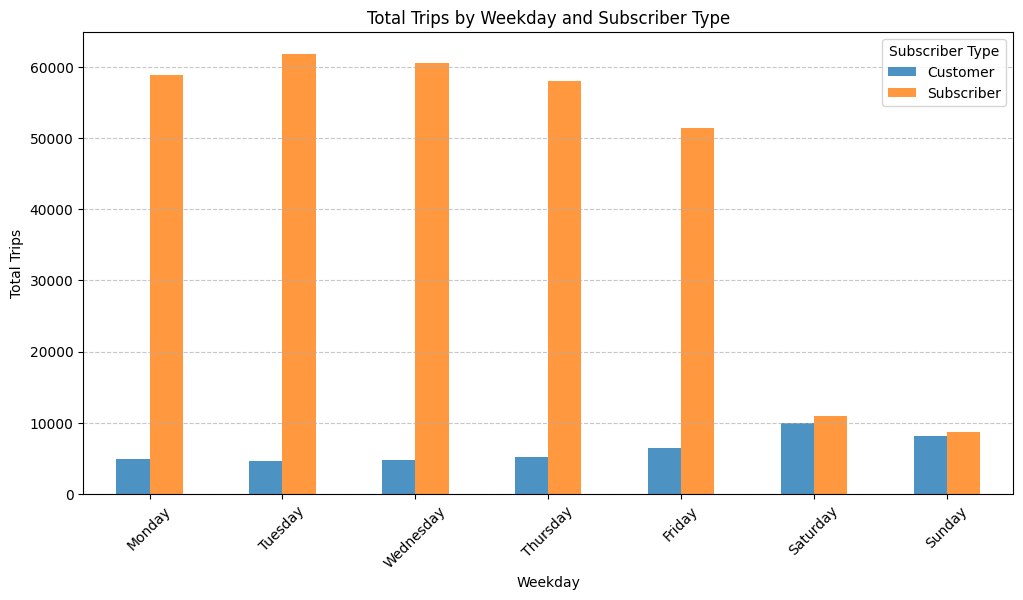

In [62]:
from pyspark.sql.functions import col, dayofweek, when, count
import matplotlib.pyplot as plt
import seaborn as sns

# Add a column for the weekday number (1 = Sunday, ..., 7 = Saturday)
final_data = final_data.withColumn("Start_weekday_num", dayofweek(col("Start_date")))

# Remap weekday numbers so Monday = 1, Sunday = 7
final_data = final_data.withColumn(
    "Start_weekday_mapped",
    when(col("Start_weekday_num") == 2, 1)  # Monday
    .when(col("Start_weekday_num") == 3, 2)  # Tuesday
    .when(col("Start_weekday_num") == 4, 3)  # Wednesday
    .when(col("Start_weekday_num") == 5, 4)  # Thursday
    .when(col("Start_weekday_num") == 6, 5)  # Friday
    .when(col("Start_weekday_num") == 7, 6)  # Saturday
    .when(col("Start_weekday_num") == 1, 7)  # Sunday
)

# Map the new weekday numbers to their names
final_data = final_data.withColumn(
    "Start_weekday",
    when(col("Start_weekday_mapped") == 1, "Monday")
    .when(col("Start_weekday_mapped") == 2, "Tuesday")
    .when(col("Start_weekday_mapped") == 3, "Wednesday")
    .when(col("Start_weekday_mapped") == 4, "Thursday")
    .when(col("Start_weekday_mapped") == 5, "Friday")
    .when(col("Start_weekday_mapped") == 6, "Saturday")
    .when(col("Start_weekday_mapped") == 7, "Sunday")
)

# Group by weekday and Subscriber Type
trips_by_weekday = (
    final_data.groupBy("Start_weekday", "Start_weekday_mapped", "Subscriber Type")
    .agg(count("*").alias("Total Trips"))
)

# Sort by Start_weekday_mapped to ensure Monday is first
trips_by_weekday = trips_by_weekday.orderBy("Start_weekday_mapped")

# Convert to Pandas DataFrame for visualization
pdf = trips_by_weekday.toPandas()

# Define the correct weekday order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Pivot data for plotting and sort by weekday order
pivot_df = pdf.pivot(index="Start_weekday", columns="Subscriber Type", values="Total Trips")
pivot_df = pivot_df.reindex(weekday_order)

# Plot grouped bar chart with default matplotlib colors (orange and blue)
ax = pivot_df.plot(kind='bar', figsize=(12, 6), color=["C0", "C1"], alpha=0.8)
plt.xlabel("Weekday")
plt.ylabel("Total Trips")
plt.title("Total Trips by Weekday and Subscriber Type")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Subscriber Type")
plt.show()


- AVERAGE TRIP DURATION BY STATION

In [63]:
# 1. Map Phase: Calculate Trip Duration and Create Key-Value Pairs
mapped_start = final_data.withColumn("Trip_Duration", 
    (unix_timestamp(col("End_time")) - unix_timestamp(col("Start_time"))) / 60
).select(
    col("Start Station").alias("Station"),
    col("Trip_Duration"),
    lit("Start").alias("Station Type")
)

mapped_end = final_data.withColumn("Trip_Duration", 
    (unix_timestamp(col("End_time")) - unix_timestamp(col("Start_time"))) / 60
).select(
    col("End Station").alias("Station"),
    col("Trip_Duration"),
    lit("End").alias("Station Type")
)

# 2. Shuffle Phase: Combine Start and End Station Data
combined_data = mapped_start.union(mapped_end)

# 3. Reduce Phase: Aggregate to Calculate Averages
avg_trip_duration_combined = combined_data.groupBy("Station", "Station Type").agg(
    round((sum("Trip_Duration") / count("Trip_Duration")), 3).alias("Avg Trip Duration (mins)")
)

# 4. Sort Phase: Sort by Average Trip Duration
avg_trip_duration_combined = avg_trip_duration_combined.orderBy(col("Avg Trip Duration (mins)").desc())

avg_trip_duration_combined.show(10)


+-------+------------+------------------------+
|Station|Station Type|Avg Trip Duration (mins)|
+-------+------------+------------------------+
|     35|         End|                  50.693|
|     35|       Start|                  41.337|
|     83|         End|                  30.517|
|     36|         End|                  30.401|
|     24|         End|                  27.602|
|     36|       Start|                  27.218|
|     60|         End|                  24.026|
|     34|         End|                  23.262|
|     85|       Start|                  23.157|
|     34|       Start|                   23.06|
+-------+------------+------------------------+
only showing top 10 rows



- Analyse how behaviours change between subscriber type

In [64]:
total_trips = final_data.count()

# Group by Subscriber Type and count trips
trips_by_user_type = final_data.groupBy("Subscriber Type").count().withColumnRenamed("count", "Total Trips")

# Add a percentage column to show the proportion of trips for each user type
trips_by_user_type = trips_by_user_type.withColumn(
    "Percentage of total trips",
    round((col("Total Trips") / total_trips) * 100, 2)
)

# Step 2: Calculate Average Trip Duration by Subscriber Type
avg_trip_duration_by_user_type = final_data.groupBy("Subscriber Type").agg(
    avg("Trip Duration").alias("Avg Trip Duration (mins)")
).withColumn(
    "Avg Trip Duration (mins)", round(col("Avg Trip Duration (mins)"), 2)
)

# Step 3: Calculate Average Temperature by Subscriber Type
avg_temperature_by_user_type = final_data.groupBy("Subscriber Type").agg(
    avg(col("Mean Temperature (C)")).alias("Avg Temperature (C)")
).withColumn(
    "Avg Temperature (C)", round(col("Avg Temperature (C)"), 2)
)

# Step 4: Combine All Results
result = trips_by_user_type \
    .join(avg_trip_duration_by_user_type, on="Subscriber Type", how="inner") \
    .join(avg_temperature_by_user_type, on="Subscriber Type", how="inner")


print("Total Trips, Average Trip Duration, and Average Temperature by Subscriber Type:")
result.show()

Total Trips, Average Trip Duration, and Average Temperature by Subscriber Type:
+---------------+-----------+-------------------------+------------------------+-------------------+
|Subscriber Type|Total Trips|Percentage of total trips|Avg Trip Duration (mins)|Avg Temperature (C)|
+---------------+-----------+-------------------------+------------------------+-------------------+
|     Subscriber|     310217|                    87.59|                    8.11|              16.15|
|       Customer|      43935|                    12.41|                   38.54|              16.65|
+---------------+-----------+-------------------------+------------------------+-------------------+



- Frequency of bike rentals by subscriber type for each hour of the day

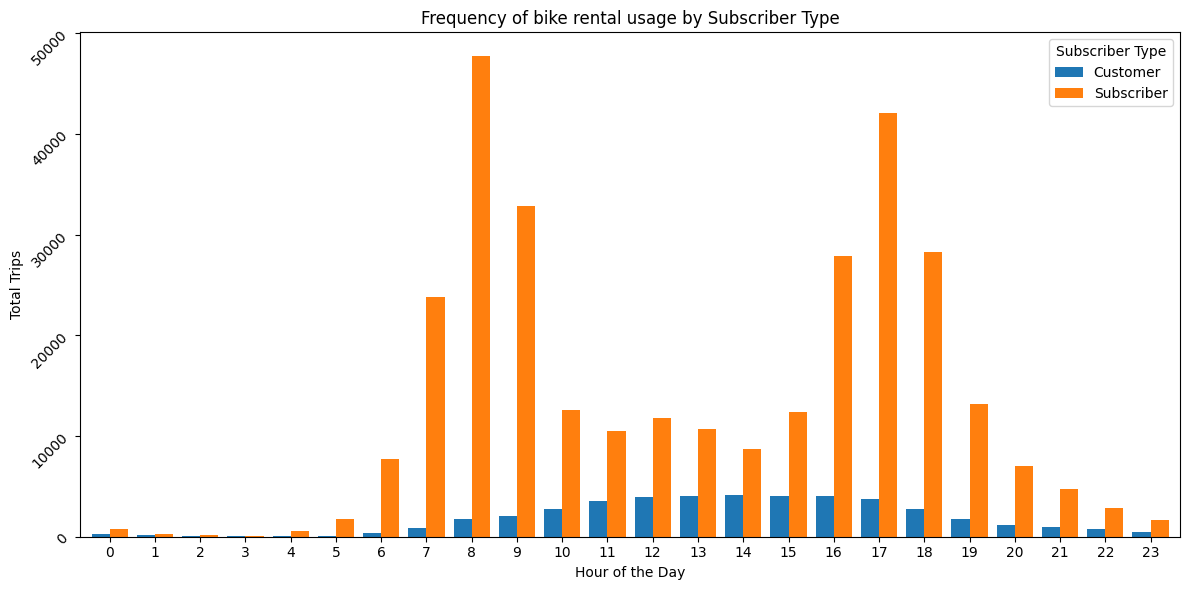

In [65]:
# Extract hour from Start_time
final_data = final_data.withColumn("Start_hour", hour(col("Start_time")))

# Group by Subscriber Type and Start_hour
peak_hours_by_user_type = final_data.groupBy("Subscriber Type", "Start_hour").count().withColumnRenamed("count", "Total Trips")

# Convert the PySpark DataFrame to a Pandas DataFrame
peak_hours_df = peak_hours_by_user_type.toPandas()

# Pivot the data for visualization
pivot_table = peak_hours_df.pivot(index="Start_hour", columns="Subscriber Type", values="Total Trips").fillna(0)

# Plot a histogram
pivot_table.plot(kind="bar", figsize=(12, 6), width=0.8)

# Customize the plot
plt.title("Frequency of bike rental usage by Subscriber Type")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Trips")
plt.xticks(rotation=0)
plt.yticks(rotation=45)
plt.legend(title="Subscriber Type")
plt.tight_layout()

plt.show()


*Average daily trips by temperature bin*

To analyze the relationship between temperature and bike usage, trips are grouped into temperature bins (rounded down). Instead of total trip counts, the average number of trips per day is calculated for each bin to ensure a fair comparison. The results are visualized in a bar chart.

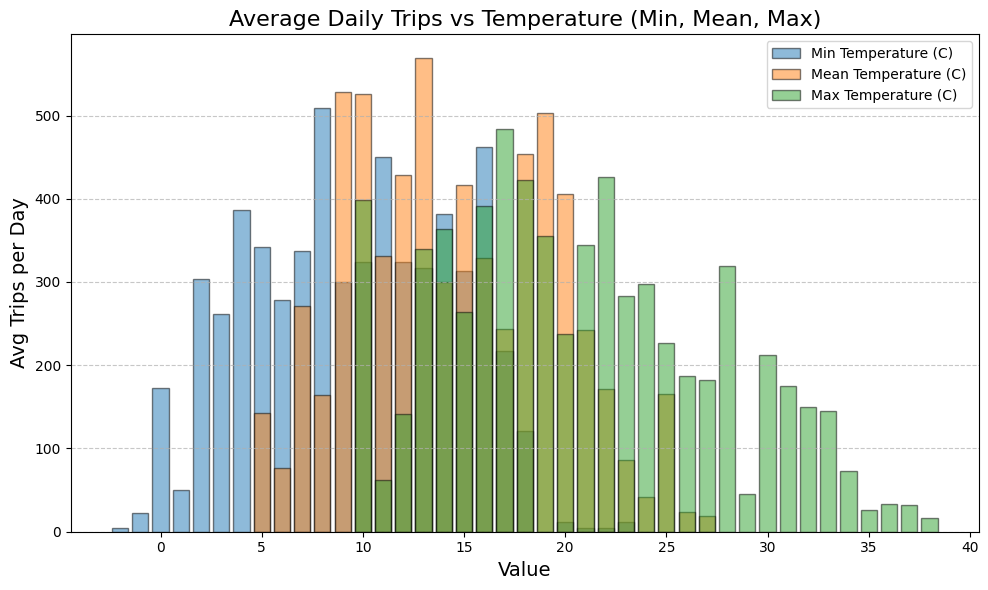

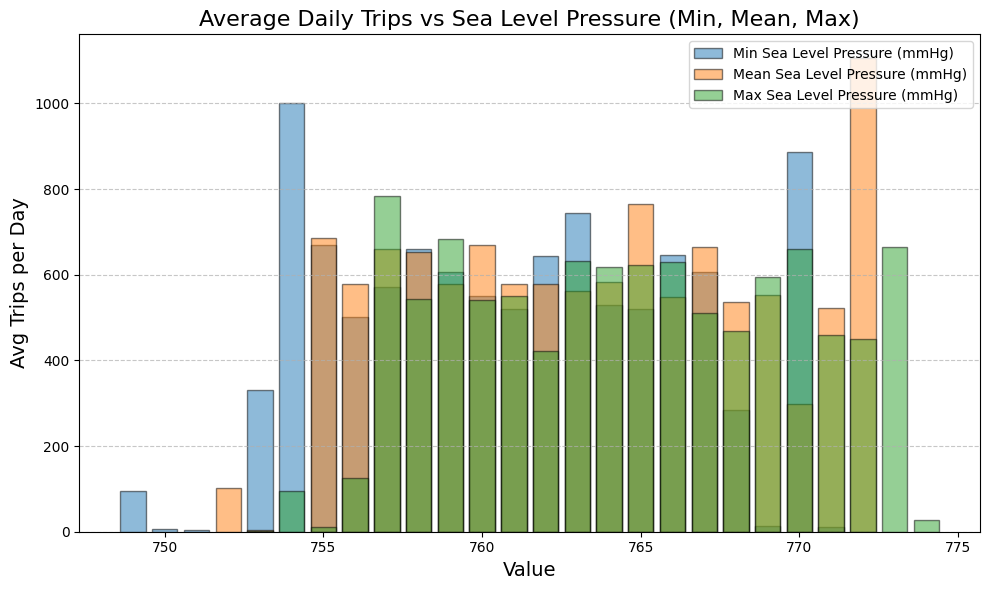

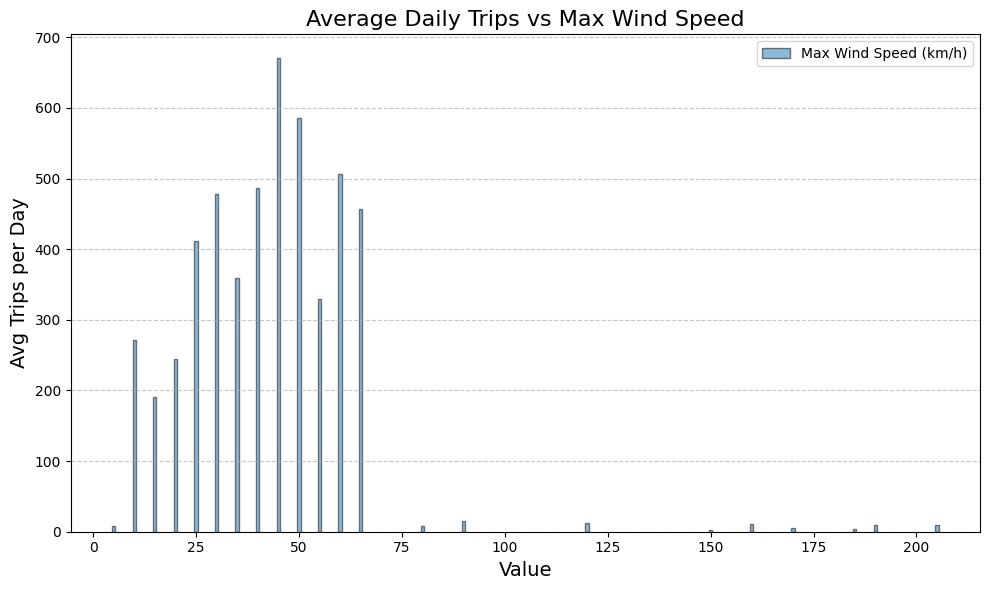

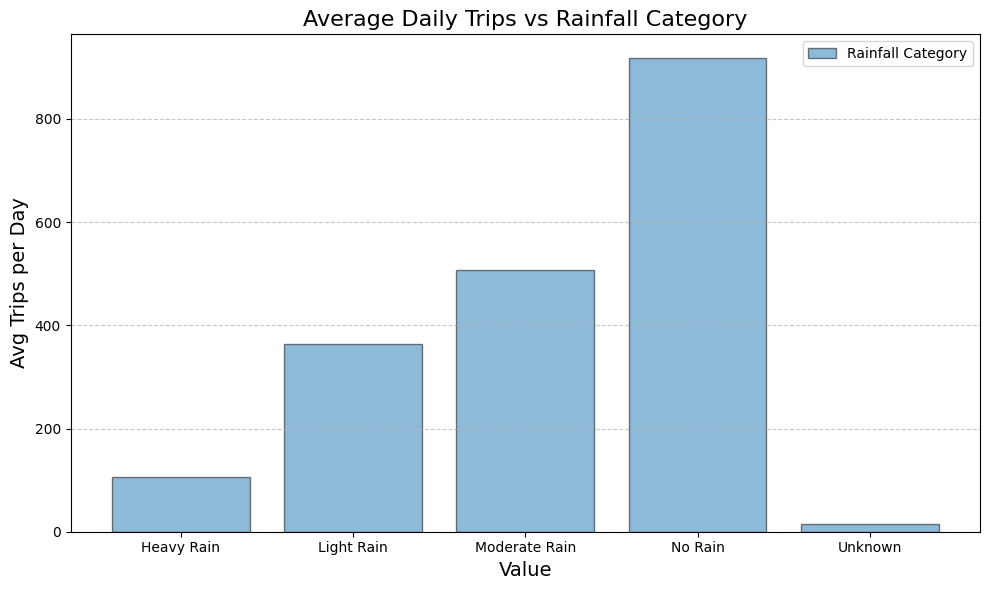

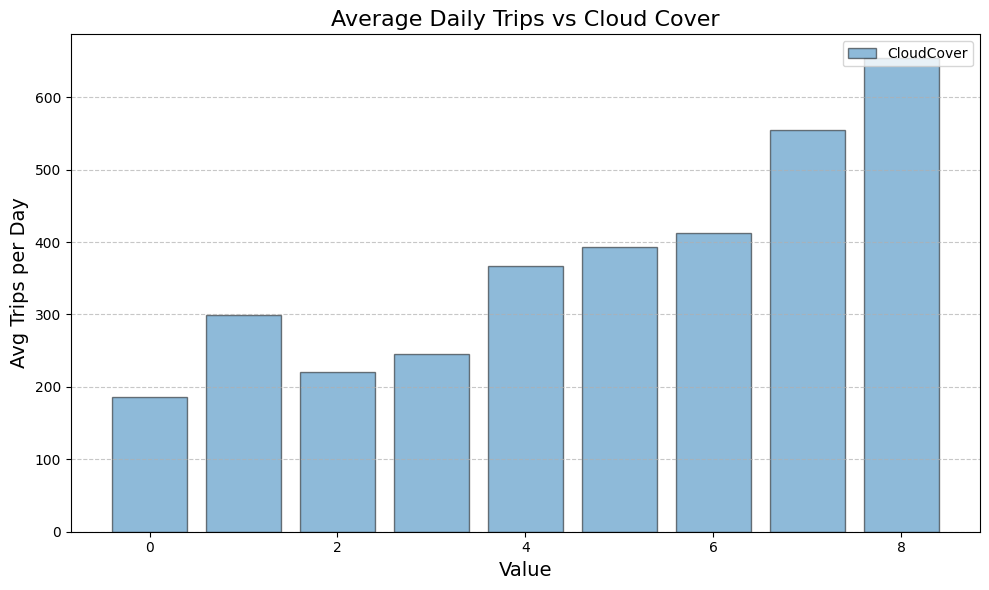

Binned grouped histograms generated and displayed.


In [66]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import year, month, dayofmonth, count, avg, floor, col
from pyspark.sql.types import FloatType

# Define groups of related columns (updated names)
temperature_cols = ["Min Temperature (C)", "Mean Temperature (C)", "Max Temperature (C)"]
pressure_cols = ["Min Sea Level Pressure (mmHg)", "Mean Sea Level Pressure (mmHg)", "Max Sea Level Pressure (mmHg)"]
wind_speed_cols = ["Max Wind Speed (km/h)"]
precipitation_col = ["Rainfall Category"]  # Categorical, no binning needed
cloud_cover_col = ["CloudCover"]

# Process temporal columns
# Extract year, month, and day for temporal variables
if "Start_date" in final_data.columns:
    final_data = final_data.withColumn("Start_year", year("Start_date"))
    final_data = final_data.withColumn("Start_month", month("Start_date"))
    final_data = final_data.withColumn("Start_day", dayofmonth("Start_date"))

if "End_date" in final_data.columns:
    final_data = final_data.withColumn("End_year", year("End_date"))
    final_data = final_data.withColumn("End_month", month("End_date"))
    final_data = final_data.withColumn("End_day", dayofmonth("End_date"))

# Function to calculate average trips per day for each bin
def plot_grouped_histogram(columns, title, bin_size=1, categorical=False):
    plt.figure(figsize=(10, 6))  # Set figure size

    for col_name in columns:
        try:
            if not categorical:
                # Ensure the column is treated as a float for calculations
                final_data_binned = final_data.withColumn(col_name, col(col_name).cast(FloatType()))
                
                # Bin values using floor function with the specified bin size
                final_data_binned = final_data_binned.withColumn(f"{col_name} Bin", floor(col(col_name) / bin_size) * bin_size)
            else:
                # Categorical variables do not need binning
                final_data_binned = final_data
                #col_name_bin = col_name

            # Group by the appropriate column and day, then count trips
            grouped_df = final_data_binned.groupBy(f"{col_name} Bin" if not categorical else col_name, "Start_year", "Start_month", "Start_day") \
                                         .agg(count("*").alias("Total_Trips"))

            # Compute the average trips per day for each bin
            avg_trips_per_bin = grouped_df.groupBy(f"{col_name} Bin" if not categorical else col_name).agg(avg("Total_Trips").alias("Avg_Trips_per_Day"))

            # Convert to Pandas for plotting
            pdf = avg_trips_per_bin.toPandas().dropna().sort_values(by=f"{col_name} Bin" if not categorical else col_name)

            # Plot histogram using average trips per day
            plt.bar(pdf[f"{col_name} Bin" if not categorical else col_name], pdf["Avg_Trips_per_Day"], alpha=0.5, label=col_name, edgecolor='k')

        except Exception as e:
            print(f"Could not process column {col_name}: {e}")

    plt.title(f"Average Daily Trips vs {title}", fontsize=16)
    plt.xlabel("Value", fontsize=14)
    plt.ylabel("Avg Trips per Day", fontsize=14)
    plt.legend(loc="upper right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Generate binned histograms
plot_grouped_histogram(temperature_cols, "Temperature (Min, Mean, Max)")
plot_grouped_histogram(pressure_cols, "Sea Level Pressure (Min, Mean, Max)", bin_size=1)
plot_grouped_histogram(wind_speed_cols, "Max Wind Speed", bin_size=5)
plot_grouped_histogram(precipitation_col, "Rainfall Category", categorical=True)
plot_grouped_histogram(cloud_cover_col, "Cloud Cover")

print("Binned grouped histograms generated and displayed.")


## 2.2 Explore data with respect to weather

*Average trip duration per Rainfall category*

To examine how rainfall influences trip length, the average trip duration is calculated for each rainfall category and sorted in descending order.

In [67]:
# Calculate the average trip duration for each rainfall category
average_trip_duration = final_data.groupBy("Rainfall Category").agg(
    round(avg("Trip Duration"), 3).alias("Average Trip Duration")
)

# Sort the results by average trip duration in descending order
sorted_average_trip_duration = average_trip_duration.orderBy(col("Average Trip Duration").desc())

# Show the result
sorted_average_trip_duration.show()

+-----------------+---------------------+
|Rainfall Category|Average Trip Duration|
+-----------------+---------------------+
|          Unknown|               78.643|
|       Heavy Rain|               20.632|
|       Light Rain|               12.295|
|          No Rain|               11.953|
|    Moderate Rain|                7.822|
+-----------------+---------------------+



Trips in heavy rain tend to last longer (~20.6 min) than in moderate or light rain. This could indicate cautious riding behavior or fewer short-distance casual trips.

Dry conditions lead to shorter average trip durations (~12 min), possibly due to more frequent short rides.

The "Unknown" category shows the longest duration (~78.6 min), likely due to data inconsistencies or outliers.

Moderate rain has the shortest trips (~7.8 min), suggesting riders may avoid prolonged exposure to wet conditions.

In [68]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col, count

# Calculate trip count for each station and rainfall category
station_trip_counts = final_data.groupBy("Start Station", "Rainfall Category").agg(
    count("*").alias("Trip Count")
)

# Define a window partitioned by rainfall category, ordered by trip count (descending)
windowSpec = Window.partitionBy("Rainfall Category").orderBy(col("Trip Count").desc())

# Add a rank column to identify the top stations per category
ranked_stations = station_trip_counts.withColumn(
    "Rank", row_number().over(windowSpec)
)

# Filter to include only the top 5 stations per category
top_5_stations = ranked_stations.filter(col("Rank") <= 5)

# Show the results
top_5_stations.select("Rainfall Category", "Start Station", "Trip Count", "Rank").show()


+-----------------+-------------+----------+----+
|Rainfall Category|Start Station|Trip Count|Rank|
+-----------------+-------------+----------+----+
|       Heavy Rain|           70|        11|   1|
|       Heavy Rain|           50|         6|   2|
|       Heavy Rain|           88|         6|   3|
|       Heavy Rain|           65|         4|   4|
|       Heavy Rain|           63|         4|   5|
|       Light Rain|           70|      1038|   1|
|       Light Rain|           88|       721|   2|
|       Light Rain|           50|       583|   3|
|       Light Rain|           60|       565|   4|
|       Light Rain|           65|       516|   5|
|    Moderate Rain|           70|       688|   1|
|    Moderate Rain|           88|       482|   2|
|    Moderate Rain|           55|       355|   3|
|    Moderate Rain|           65|       335|   4|
|    Moderate Rain|           50|       331|   5|
|          No Rain|           70|     24567|   1|
|          No Rain|           88|     20549|   2|


# 3. Station Importance Ranking Using PageRank

### Step 3.1. Preprocess the Dataset
Let's build the directed graph:

Nodes = unique bike stations.\
Edges = directed trips between stations (weighted by the frequency of trips).

In [69]:
from pyspark.sql import functions as F

# Group by start and end stations to calculate the number of trips (weights)
edge_weights = final_data.groupBy("Start Station", "End Station") \
    .agg(F.count("*").alias("weight"))

# Collect all unique stations (nodes)
nodes = edge_weights.select("Start Station").union(edge_weights.select("End Station")).distinct()

In [70]:
print(edge_weights.show(4))

+-------------+-----------+------+
|Start Station|End Station|weight|
+-------------+-----------+------+
|           65|         50|   827|
|           68|         57|   270|
|           62|         87|   327|
|           64|         48|   169|
+-------------+-----------+------+
only showing top 4 rows

None


#### Step 2.2 Build the Transition Matrix
Represent the trips as a transition matrix. Each element 𝑀𝑖𝑗 in the matrix represents the probability of moving from station 𝑗 to station 𝑖.

1- Calculate the total outgoing trips for each station.

2- Normalize edge weights to get probabilities.

In [71]:
# Calculate total outgoing trips for each station
total_outgoing = edge_weights.groupBy("Start Station") \
    .agg(F.sum("weight").alias("total_weight"))

# Join with edge weights to calculate probabilities
transition_df = edge_weights.join(total_outgoing, on="Start Station") \
    .withColumn("probability", round(F.col("weight") / F.col("total_weight"), 4))

# Transition matrix rows: Start Station, End Station, Probability
transition_df.show()

# weight represents the number of trips from the start station to the end station (frq of trips)
# total_weight is the total number of trips from start station to all other stations

+-------------+-----------+------+------------+-----------+
|Start Station|End Station|weight|total_weight|probability|
+-------------+-----------+------+------------+-----------+
|           65|         50|   827|       13752|     0.0601|
|           68|         57|   270|        5523|     0.0489|
|           62|         87|   327|        7999|     0.0409|
|           64|         48|   169|        9469|     0.0178|
|            2|         80|    15|        4968|      0.003|
|           90|         64|   114|        7760|     0.0147|
|           68|         74|   206|        5523|     0.0373|
|           51|         50|   155|        7596|     0.0204|
|           59|         46|    24|        3646|     0.0066|
|           45|         70|   621|        6014|     0.1033|
|           10|          2|   295|         832|     0.3546|
|           71|         42|   256|        6425|     0.0398|
|           32|         27|    49|        1230|     0.0398|
|           47|         45|   113|      

#### Step 2.3. Implement the PageRank Algorithm
Use NumPy to compute PageRank iteratively.

Collect the transition_df data into a NumPy matrix.

In [72]:
import numpy as np

# Map stations to indices
station_list = nodes.collect()
station_to_index = {row[0]: idx for idx, row in enumerate(station_list)}
n = len(station_list)  # Total number of stations

# Initialize transition matrix with zeros
M = np.zeros((n, n))

# Fill in the transition probabilities
for row in transition_df.collect():
    start_idx = station_to_index[row["Start Station"]]
    end_idx = station_to_index[row["End Station"]]
    M[end_idx, start_idx] = row["probability"]  # Note: M[end][start] for directed edge

Initialize the PageRank Vector: use a uniform distribution to start.

In [73]:
v = np.ones(n) / n  # Uniform distribution

Iteratively Compute PageRank:

In [74]:
d = 0.85  # Damping factor
e = np.ones(n) / n  # Uniform jump vector

iterations = 100  # Number of iterations
for _ in range(iterations):
    v = d * (M @ v) + (1 - d) * e

Intuition behind v:\
The proportion of time a random biker would spend at station 𝑖 if they took an infinite number of trips.
A measure of the station’s connectivity and influence in the network.

Map the computed PageRank values back to the station names.

In [75]:
# Map indices back to station names
station_ranks = [(station_list[i][0], rank) for i, rank in enumerate(v)]
station_ranks.sort(key=lambda x: x[1], reverse=True)  # Sort by rank (descending)

# Display top 10 stations
print("Top 10 Stations by PageRank:")
for station, rank in station_ranks[:10]:
    print(f"Station: {station}, PageRank: {rank:.4f}")


Top 10 Stations by PageRank:
Station: 2, PageRank: 0.0565
Station: 70, PageRank: 0.0480
Station: 28, PageRank: 0.0359
Station: 88, PageRank: 0.0319
Station: 22, PageRank: 0.0318
Station: 50, PageRank: 0.0262
Station: 61, PageRank: 0.0225
Station: 65, PageRank: 0.0224
Station: 60, PageRank: 0.0223
Station: 4, PageRank: 0.0219


Why is PageRank Useful for Bike Stations?

- Identify Hubs: Stations with high PageRank are central hubs where many trips either start or end.\
- Optimize Operations: Knowing which stations are central can help prioritize bike redistribution efforts.\
- User Flow Insights: Understand patterns of user movement and how stations interact within the network.\
- Infrastructure Planning: Focus investments (e.g., adding docks or bikes) on high-importance stations.

In [76]:
# all in one chunck
from pyspark.sql import functions as F

# Group by start and end stations to calculate the number of trips (weights)
edge_weights = final_data.groupBy("Start Station", "End Station") \
    .agg(F.count("*").alias("weight"))

# Collect all unique stations (nodes)
nodes = edge_weights.select("Start Station").union(edge_weights.select("End Station")).distinct()

# Calculate total outgoing trips for each station
total_outgoing = edge_weights.groupBy("Start Station") \
    .agg(F.sum("weight").alias("total_weight"))

# Join with edge weights to calculate probabilities
transition_df = edge_weights.join(total_outgoing, on="Start Station") \
    .withColumn("probability", round(F.col("weight") / F.col("total_weight"), 4))

# weight represents the number of trips from the start station to the end station (frq of trips)
# total_weight is the total number of trips from start station to all other stations

import numpy as np

# Map stations to indices
station_list = nodes.collect()
station_to_index = {row[0]: idx for idx, row in enumerate(station_list)}
n = len(station_list)  # Total number of stations

# Initialize transition matrix with zeros
M = np.zeros((n, n))

# Fill in the transition probabilities
for row in transition_df.collect():
    start_idx = station_to_index[row["Start Station"]]
    end_idx = station_to_index[row["End Station"]]
    M[end_idx, start_idx] = row["probability"]  # Note: M[end][start] for directed edge

v = np.ones(n) / n  # Uniform distribution

d = 0.85  # Damping factor
e = np.ones(n) / n  # Uniform jump vector

iterations = 100  # Number of iterations
for _ in range(iterations):
    v = d * (M @ v) + (1 - d) * e

# Map indices back to station names
station_ranks = [(station_list[i][0], rank) for i, rank in enumerate(v)]
station_ranks.sort(key=lambda x: x[1], reverse=True)  # Sort by rank (descending)

# Display top 10 stations
print("Top 10 Stations by PageRank:")
for station, rank in station_ranks[:10]:
    print(f"Station: {station}, PageRank: {rank:.4f}")

Top 10 Stations by PageRank:
Station: 2, PageRank: 0.0565
Station: 70, PageRank: 0.0480
Station: 28, PageRank: 0.0359
Station: 88, PageRank: 0.0319
Station: 22, PageRank: 0.0318
Station: 50, PageRank: 0.0262
Station: 61, PageRank: 0.0225
Station: 65, PageRank: 0.0224
Station: 60, PageRank: 0.0223
Station: 4, PageRank: 0.0219


### Using the already implemented algorithm

In [77]:
import networkx as nx
import pandas as pd

# Convert PySpark DataFrame to Pandas
edge_weights_pd = edge_weights.toPandas()

# Create a directed graph
G = nx.DiGraph()

# Add weighted edges (trips between stations)
for _, row in edge_weights_pd.iterrows():
    G.add_edge(row["Start Station"], row["End Station"], weight=row["weight"])

# Apply NetworkX PageRank
pagerank_scores = nx.pagerank(G, alpha=0.85)  # damping factor = 0.85

# Convert results to a DataFrame
pagerank_df = pd.DataFrame(list(pagerank_scores.items()), columns=["Station", "PageRank"])

# Sort by PageRank score
pagerank_df = pagerank_df.sort_values(by="PageRank", ascending=False).reset_index(drop=True)

# Display the top 10 stations
print("Top 10 Stations by NetworkX PageRank:")
print(pagerank_df.head(10))


Top 10 Stations by NetworkX PageRank:
   Station  PageRank
0        2  0.056481
1       70  0.047973
2       28  0.035848
3       22  0.031898
4       88  0.031857
5       50  0.026233
6       61  0.022510
7       65  0.022352
8       60  0.022286
9        4  0.021919


### Compare results

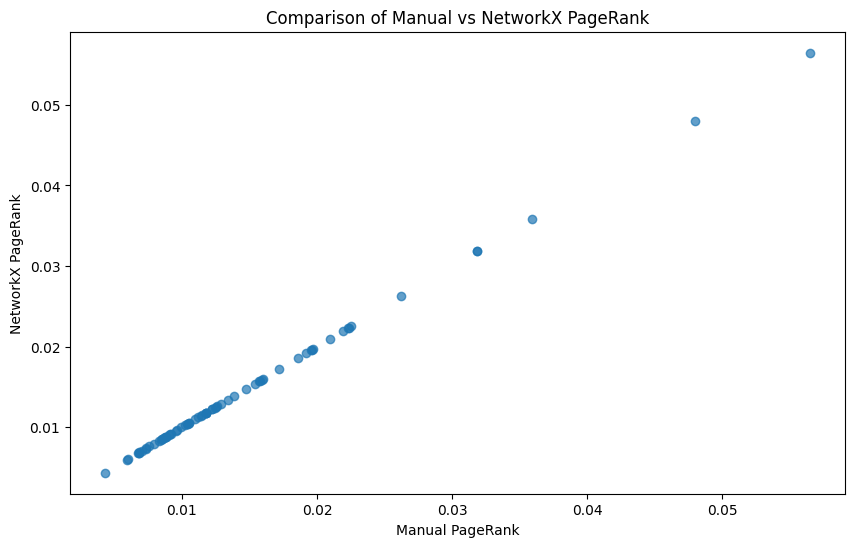

Pearson Correlation: 1.0000


In [78]:
# Convert your manually computed PageRank to Pandas DataFrame
manual_pagerank_df = pd.DataFrame(station_ranks, columns=["Station", "Manual_PageRank"])
# Merge manual and NetworkX PageRank results
comparison_df = manual_pagerank_df.merge(pagerank_df, on="Station", how="inner")
# Merge manual and NetworkX PageRank results
comparison_df = manual_pagerank_df.merge(pagerank_df, on="Station", how="inner")
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(comparison_df["Manual_PageRank"], comparison_df["PageRank"], alpha=0.7)
plt.xlabel("Manual PageRank")
plt.ylabel("NetworkX PageRank")
plt.title("Comparison of Manual vs NetworkX PageRank")
plt.show()


from scipy.stats import pearsonr

pearson_corr, _ = pearsonr(comparison_df["Manual_PageRank"], comparison_df["PageRank"])
print(f"Pearson Correlation: {pearson_corr:.4f}")

In [79]:
final_data.show(2)

+-------+-------------+-----------+---------------+----------+----------+-------------------+-------------------+-------------------+--------------------+-------------------+-----------------------------+------------------------------+-----------------------------+---------------------+------------------+----------+-----+--------------------+------------------+---------+-----------+----------------+--------------------+----------------+---------+-----------+--------------+-----------------+-------------+-----------------+--------------------+-------------+----------+----------+-----------+---------+--------+---------+-------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|  End_date|         Start_time|           End_time|Max Temperature (C)|Mean Temperature (C)|Min Temperature (C)|Max Sea Level Pressure (mmHg)|Mean Sea Level Pressure (mmHg)|Min Sea Level Pressure (mmHg)|Max Wind Speed (km/h)|Precipitation (mm)|CloudCover|  Zip|  Start_Station_Name|Start_Station_City|Sta

How the ranking changes according to different months

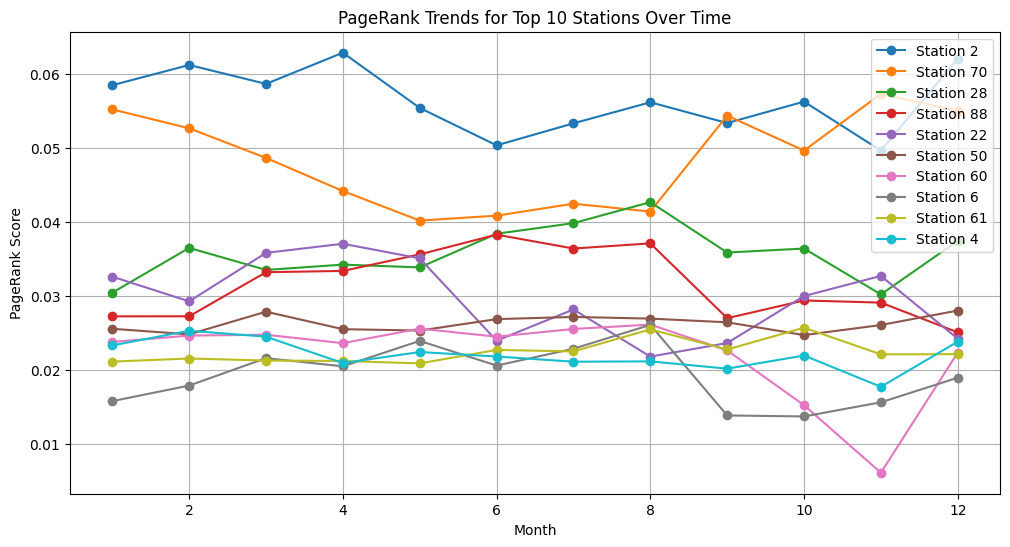

In [80]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas
edge_weights_pd = final_data.toPandas()

# Create an empty dictionary to store PageRank results for each month
monthly_pagerank = {}

# Iterate over each unique month in the dataset
for month in edge_weights_pd["Start_month"].unique():
    
    # Filter data for the specific month
    monthly_edges = edge_weights_pd[edge_weights_pd["Start_month"] == month]
    
    # Compute trip frequencies (weights)
    edge_counts = monthly_edges.groupby(["Start Station", "End Station"]).agg(weight=("Trip ID", "count")).reset_index()
    
    # Create a directed graph for the month
    G = nx.DiGraph()

    # Add weighted edges (trips between stations)
    for _, row in edge_counts.iterrows():
        G.add_edge(row["Start Station"], row["End Station"], weight=row["weight"])

    # Compute PageRank for the month
    pagerank_scores = nx.pagerank(G, alpha=0.85)

    # Convert to DataFrame and store the results
    pagerank_df = pd.DataFrame(list(pagerank_scores.items()), columns=["Station", "PageRank"])
    pagerank_df["Month"] = month
    monthly_pagerank[month] = pagerank_df

# Combine results into a single DataFrame
all_months_pagerank_df = pd.concat(monthly_pagerank.values(), ignore_index=True)

# Pivot the DataFrame to get months as rows and stations as columns
pivot_df = all_months_pagerank_df.pivot(index="Month", columns="Station", values="PageRank")

# Reset index for a clean format
pivot_df.reset_index(inplace=True)

# Plot PageRank trends for the most significant stations
plt.figure(figsize=(12, 6))
num_top_stations = 10  # Increase to top 10 stations

# Identify top stations by their highest PageRank in any month
top_stations = all_months_pagerank_df.groupby("Station")["PageRank"].max().sort_values(ascending=False).index[:num_top_stations]

for station in top_stations:
    if station in pivot_df.columns:
        plt.plot(pivot_df["Month"], pivot_df[station], marker='o', linestyle='-', label=f"Station {station}")

plt.xlabel("Month")
plt.ylabel("PageRank Score")
plt.title("PageRank Trends for Top 10 Stations Over Time")
plt.legend()
plt.grid(True)
plt.show()


Processing PageRank for Rainfall Category (rain-norain): No Rain
Processing PageRank for Rainfall Category (rain-norain): Rain


C:\Users\utente\AppData\Local\Temp\ipykernel_16712\1829938667.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_top_stations).colors if num_top_stations <= 10 else plt.cm.get_cmap("tab20", num_top_stations).colors


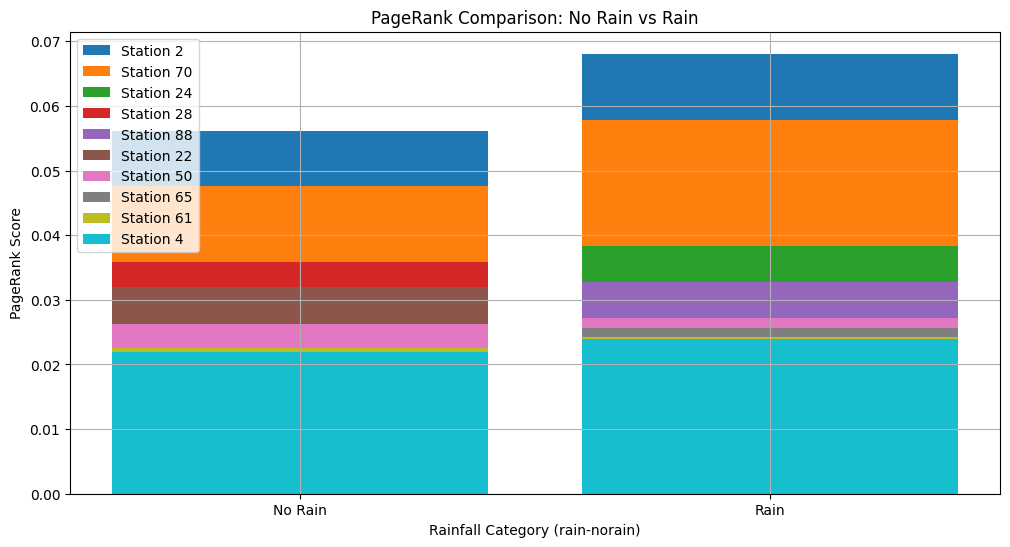

In [83]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col, when

# Categorize precipitation into two levels: "No Rain" and "Rain"
final_data = final_data.withColumn(
    "Rainfall Category (rain-norain)",
    when(col("Precipitation (mm)") <= 1, "No Rain").otherwise("Rain")
)

# Convert PySpark DataFrame to Pandas
edge_weights_pd = final_data.toPandas()

# Create an empty dictionary to store PageRank results for each rainfall category
rain_pagerank = {}

# Iterate over each unique rain category in the dataset
for rain_category in edge_weights_pd["Rainfall Category (rain-norain)"].unique():
    print(f"Processing PageRank for Rainfall Category (rain-norain): {rain_category}")

    # Filter data for the specific rainfall category
    category_edges = edge_weights_pd[edge_weights_pd["Rainfall Category (rain-norain)"] == rain_category]
    
    # Compute trip frequencies (weights)
    edge_counts = category_edges.groupby(["Start Station", "End Station"]).agg(weight=("Trip ID", "count")).reset_index()
    
    # Create a directed graph for the rainfall category
    G = nx.DiGraph()

    # Add weighted edges (trips between stations)
    for _, row in edge_counts.iterrows():
        G.add_edge(row["Start Station"], row["End Station"], weight=row["weight"])

    # Compute PageRank for the rainfall category
    pagerank_scores = nx.pagerank(G, alpha=0.85)

    # Convert to DataFrame and store the results
    pagerank_df = pd.DataFrame(list(pagerank_scores.items()), columns=["Station", "PageRank"])
    pagerank_df["Rainfall Category (rain-norain)"] = rain_category
    rain_pagerank[rain_category] = pagerank_df

# Combine results into a single DataFrame
all_rain_pagerank_df = pd.concat(rain_pagerank.values(), ignore_index=True)

# Pivot the DataFrame to get rainfall categories as rows and stations as columns
pivot_df = all_rain_pagerank_df.pivot(index="Rainfall Category (rain-norain)", columns="Station", values="PageRank")

# Reset index for a clean format
pivot_df.reset_index(inplace=True)

# Define a list of distinct colors for better differentiation
colors = plt.cm.get_cmap("tab10", num_top_stations).colors if num_top_stations <= 10 else plt.cm.get_cmap("tab20", num_top_stations).colors

# Plot PageRank trends for the most significant stations
plt.figure(figsize=(12, 6))
num_top_stations = 10  # Increase to top 10 stations

# Identify top stations by their highest PageRank in any category
top_stations = all_rain_pagerank_df.groupby("Station")["PageRank"].max().sort_values(ascending=False).index[:num_top_stations]

for i, station in enumerate(top_stations):
    if station in pivot_df.columns:
        plt.bar(pivot_df["Rainfall Category (rain-norain)"], pivot_df[station], label=f"Station {station}", color=colors[i % len(colors)])

plt.xlabel("Rainfall Category (rain-norain)")
plt.ylabel("PageRank Score")
plt.title("PageRank Comparison: No Rain vs Rain")
plt.legend()
plt.grid(True)
plt.show()